In [1]:
!pip install transformers==3

     |████████████████████████████████| 757kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 15.5MB/s 
     |████████████████████████████████| 890kB 41.1MB/s 
     |████████████████████████████████| 3.0MB 55.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=64598d5d0296a9531a7f0fcc46ec9c4b964c609de5fee7d0efcf87dc0762ece7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
#http://mccormickml.com/2019/07/22/BERT-fine-tuning/
#https://github.com/abhimishra91/pytorch-tutorials/blob/master/lecture_08_a.ipynb
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [10]:
raw_data_path = '/content/drive/My Drive/NLP/ResearchArticlesClassification/Dataset/raw_train.csv'
destination_folder = '/content/drive/My Drive/NLP/ResearchArticlesClassification/Dataset'

df_raw =  pd.read_csv(raw_data_path)

df_raw.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [11]:
df_raw.shape

(20972, 9)

In [12]:
df_raw.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [13]:
df_raw['target_list'] = df_raw[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values.tolist()

In [15]:
df_raw.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,target_list
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[1, 0, 0, 1, 0, 0]"


In [16]:
df_raw['WORD_COUNT'] = df_raw['ABSTRACT'].apply(lambda x: len(x.split()))
df_raw.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,target_list,WORD_COUNT
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]",265
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]",76
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",99
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]",110
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[1, 0, 0, 1, 0, 0]",125


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f615ecb0240>]],
      dtype=object)

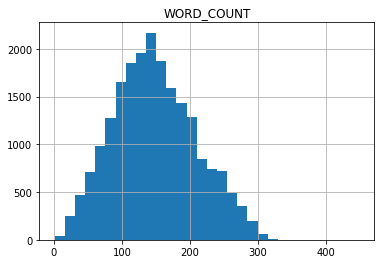

In [17]:
df_raw.hist('WORD_COUNT', bins=30)

In [18]:
df2 = df_raw[['ABSTRACT', 'target_list']].copy()
df2.head()

,ABSTRACT,target_list
0,Predictive models allow subject-specific inf...,"[1, 0, 0, 0, 0, 0]"
1,Rotation invariance and translation invarian...,"[1, 0, 0, 0, 0, 0]"
2,We introduce and develop the notion of spher...,"[0, 0, 1, 0, 0, 0]"
3,The stochastic Landau--Lifshitz--Gilbert (LL...,"[0, 0, 1, 0, 0, 0]"
4,Fourier-transform infra-red (FTIR) spectra o...,"[1, 0, 0, 1, 0, 0]"


In [19]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['ABSTRACT']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [21]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20972, 2)
TRAIN Dataset: (16778, 2)
TEST Dataset: (4194, 2)


In [22]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [23]:
len(training_loader)

525

In [24]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil
# bert to get the final output for the model. 

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [25]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [26]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [27]:
len(training_loader)

525

In [28]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [29]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [30]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [32]:
#this is joe method
#https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [34]:
'''start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, optimizer,
                checkpoint_path, best_model_path):
'''
checkpoint_path = '/content/drive/My Drive/NLP/ResearchArticlesClassification/checkpoint/current_checkpoint.pt'
best_model = '/content/drive/My Drive/NLP/ResearchArticlesClassification/best_model/best_model.pt'
trained_model = train_model(1, 5, np.Inf, training_loader, validation_loader, model, 
                      optimizer,checkpoint_path,best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000340 	Average Validation Loss: 0.001363
Validation loss decreased (inf --> 0.001363).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000286 	Average Validation Loss: 0.001316
Validation loss decreased (0.001363 --> 0.001316).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [ ]:
#fin_outputs
#print(fin_targets)

In [35]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [36]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6647194404705135
F1 Score (Micro) = 0.8170700555591034
F1 Score (Macro) = 0.7244991837056244


In [37]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [38]:
cm_labels = ['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']
    
cm = mcm(val_targets, val_preds)

In [39]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83     10428
           1       0.90      0.88      0.89      7020
           2       0.82      0.78      0.80      6744
           3       0.75      0.80      0.78      6312
           4       0.62      0.36      0.45       786
           5       0.75      0.50      0.60       252

   micro avg       0.82      0.81      0.82     31542
   macro avg       0.78      0.69      0.72     31542
weighted avg       0.82      0.81      0.82     31542
 samples avg       0.84      0.84      0.83     31542



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

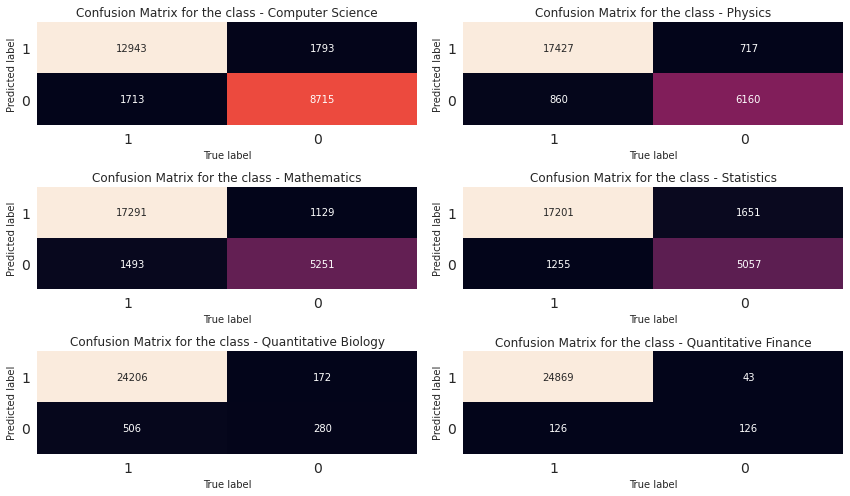

In [41]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()

## Inference

In [42]:
test_df = pd.read_csv('/content/drive/My Drive/NLP/ResearchArticlesClassification/Dataset/test.csv')
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [43]:
test_df.shape

(8989, 3)

In [45]:
class PrepForPredictionDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['ABSTRACT']
        #self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
           # 'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


In [46]:
testing_set = PrepForPredictionDataset(test_df, tokenizer, MAX_LEN)
testing_set[0]

{'ids': tensor([  101,  2057,  2556,  3117,  4824,  2015,  1997,  1996, 13091,  1011,
         13433, 24077,  1006,  6578,  1007,  2944,  1010,  1037,  4013,  3676,
         27965,  4588,  8185,  5387,  3989,  2944,  2005,  4175,  2951,  1012,
          2057,  2265,  2008,  6578,  2064,  2022,  2128, 15773,  2489,  1997,
          1996,  3556,  1013, 13791,  8185,  1012,  2023,  3957,  2149,  2047,
         20062,  2055,  1996, 24155,  1997,  1996,  8476,  1013,  9206,  8185,
          2011,  4555, 14785, 16593, 24155,  1012,  1999,  3327,  1010,  2023,
          7607,  1996, 15873,  2791,  1997,  2023,  9765,  9581,  4263,  2000,
          2058,  1011,  9675,  5300,  1997,  1996,  5387,  3989,  4635,  1010,
          2926,  2049,  3754,  2000,  8073, 10975,  9816, 22537,  9206,  7753,
          1010,  2004, 17537,  2135,  5159,  1999,  3025,  2147,  1012,  1996,
         14785,  3989,  1997,  1996, 13791,  8185,  5260,  1999,  2735,  2000,
          1037,  2047, 10125,  9758, 17626,  

In [47]:
testing_loader = DataLoader(testing_set, **test_params)

In [48]:
def do_prediction(loader):
    model.eval()
   
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            #fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [49]:
pred_outputs = do_prediction(testing_loader)

In [50]:
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)

In [51]:
pred_outputs

array([[0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [52]:
df_raw.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance',
       'target_list', 'WORD_COUNT'],
      dtype='object')

In [53]:
'''
computer_list = []
phy_list = []
math_list = []
stat_list = []
bio_list = []
finance_list = []
count = 0
for i in outputs[1]:
  computer_list.append(int(i[0]))
  phy_list.append(int(i[1]))
  math_list.append(int(i[2]))
  stat_list.append(int(i[3]))
  bio_list.append(int(i[4]))
  finance_list.append(int(i[5]))
  '''

'\ncomputer_list = []\nphy_list = []\nmath_list = []\nstat_list = []\nbio_list = []\nfinance_list = []\ncount = 0\nfor i in outputs[1]:\n  computer_list.append(int(i[0]))\n  phy_list.append(int(i[1]))\n  math_list.append(int(i[2]))\n  stat_list.append(int(i[3]))\n  bio_list.append(int(i[4]))\n  finance_list.append(int(i[5]))\n  '

In [54]:
preds_df = pd.DataFrame(pred_outputs, columns =['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']) 
preds_df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0,0,1,1,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0


In [55]:
preds_df.shape

(8989, 6)

In [56]:
df_concat = pd.concat([test_df, preds_df], axis=1)
df_concat.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,0,0,1,1,0,0
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,0,1,0,0,0,0
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,1,0,0,0,0,0
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,0,1,0,0,0,0
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,1,0,0,0,0,0


In [57]:
b = df_concat[['ID','Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

In [58]:
b.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,1,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0


In [60]:
b.to_csv('/content/drive/My Drive/NLP/ResearchArticlesClassification/Outputs/abstract_only.csv', index=False)

In [61]:
from google.colab import files

In [62]:
files.download('/content/drive/My Drive/NLP/ResearchArticlesClassification/Outputs/abstract_only.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>